
# Milne-Eddington Inversions of a SIMULATED dataset


In [1]:
# Our good old packages for inversion, numerical manipulation and plotting...
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

# You might remember this one, this allows us to load fits files into numpy arrays
from astropy.io import fits

In [2]:
#Load the data
data = fits.open('/home/milic/data/muram_from_rebecca/slanted_by_rce/SIRprofiles_plage_LOS_65.fits')

In [3]:
data.info()

Filename: /home/milic/data/muram_from_rebecca/slanted_by_rce/SIRprofiles_plage_LOS_65.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (4, 1536, 1536, 302)   float64   
  1                1 ImageHDU         6   (302,)   float64   
  2                1 ImageHDU         6   (302,)   float64   


In [4]:
ll = fits.open('/home/milic/data/muram_from_rebecca/slanted_by_rce/SIRprofiles_plage_LOS_65.fits')[1].data[101:]

In [5]:
print(ll)

[-500. -490. -480. -470. -460. -450. -440. -430. -420. -410. -400. -390.
 -380. -370. -360. -350. -340. -330. -320. -310. -300. -290. -280. -270.
 -260. -250. -240. -230. -220. -210. -200. -190. -180. -170. -160. -150.
 -140. -130. -120. -110. -100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.
  -20.  -10.    0.   10.   20.   30.   40.   50.   60.   70.   80.   90.
  100.  110.  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.
  220.  230.  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.
  340.  350.  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.
  460.  470.  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.
  580.  590.  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.
  700.  710.  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.
  820.  830.  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.
  940.  950.  960.  970.  980.  990. 1000. 1010. 1020. 1030. 1040. 1050.
 1060. 1070. 1080. 1090. 1100. 1110. 1120. 1130. 11

In [6]:
ll = ll * 0.001 + 6301.49

In [7]:
stokes_test = np.copy(data[0].data[101:,:200,:200,:])
stokes_test = stokes_test.transpose(1,2,3,0)
print (stokes_test.shape)

(200, 200, 4, 201)


In [8]:
# Everything looks good (actually this is the same thing as the one we studied on the first day)
# We will normalize our data as before
# Mean over all the spatial points and the last 10 wavelengths
qs = np.mean(stokes_test[:,:,0,-10:])
stokes_test /= qs

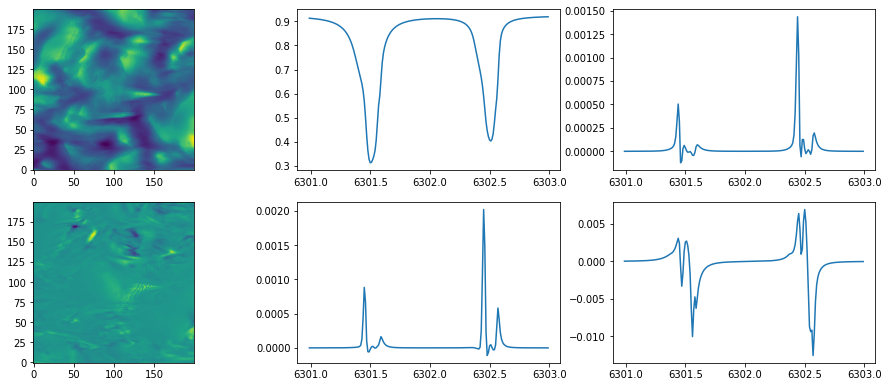

In [9]:
# Let's plot one example Stokes profile
i=110
j=130
plt.figure(figsize=[16,6.5])
plt.subplot(231)
plt.imshow(stokes_test[:,:,0,0],origin='lower')
plt.subplot(234)
plt.imshow(stokes_test[:,:,3,30],origin='lower')
plt.subplot(232)
plt.plot(ll,stokes_test[i,j,0])
plt.subplot(233)
plt.plot(ll,stokes_test[i,j,1])
plt.subplot(235)
plt.plot(ll,stokes_test[i,j,2])
plt.subplot(236)
plt.plot(ll,stokes_test[i,j,3])

In [10]:
# We are inverting only the first one
ll_to_fit = ll[100:]
regions = [[ll_to_fit, None]]

# These are the lines
lines   = [6302]
# so now our code has wavelength grid and knows what to do

me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

line::line: Initialized [6302.493100] ->   3 Zeeman components


In [11]:
# We need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 5. #noise is typicaly larger for I, because of systematics - Discuss!

In [18]:
%%time 
# This will tell us how much time we use

NX = 1536
NY = 1536

model_fit = np.zeros([1536,1536,10])

chunksx = 4
chunksy = 4

# Starting value for everyone
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])

for i in range(0,chunksx):
    for j in range(0,chunksy):
        
        nxi = NX//chunksx
        nyi = NY//chunksy
        
        xstart = i* nxi
        xend = (i+1) * nxi
        ystart = j* nyi
        yend = (j+1) * nyi
        
        models_guess = me.repeat_model(model_guess, nxi, nyi)

        # Select a Stokes subset to fit:
        to_fit = np.copy(data[0].data[201:,xstart:xend,ystart:yend,:])
        to_fit = to_fit.transpose(1,2,3,0)
        print(to_fit.shape)
        
        model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 10, nIter=25, chi2_thres=1.0, verbose=False)
        
        model_fit[xstart:xend,ystart:yend,:9] = np.copy(model_out)
        model_fit[xstart:xend,ystart:yend,9] = np.copy(chi2)
        
        del(model_out)
        del(syn_out)
        del(chi2)
        del(to_fit)

(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)


InvertMany: Processed -> 100%


(384, 384, 4, 101)
CPU times: user 4h 33min 12s, sys: 12.4 s, total: 4h 33min 24s
Wall time: 34min 35s


InvertMany: Processed -> 100%


In [19]:
print(model_fit.shape)

(1536, 1536, 10)


Well well well, look at that. Our parameters are also a cube now. And we even have a separate $\chi^2$ for each pixel! Looks great. Let's start by plotting $\chi^2$ map:

In [2]:
model_fit = fits.open("inverted_original.fits")[0].data
model_fit.shape

(1536, 1536, 10)

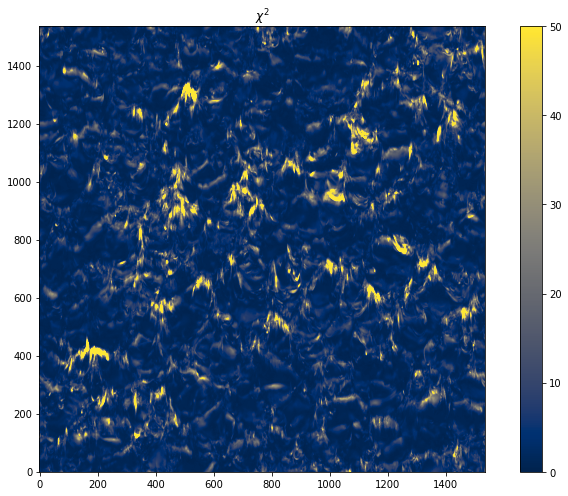

In [3]:
plt.figure(figsize=[10,7])
plt.imshow(model_fit[:,:,-1].T,cmap='cividis',origin='lower',vmin=0,vmax=50)
plt.title("$\chi^2$")
plt.colorbar()
plt.tight_layout()

Now, let's plot some parameter maps:

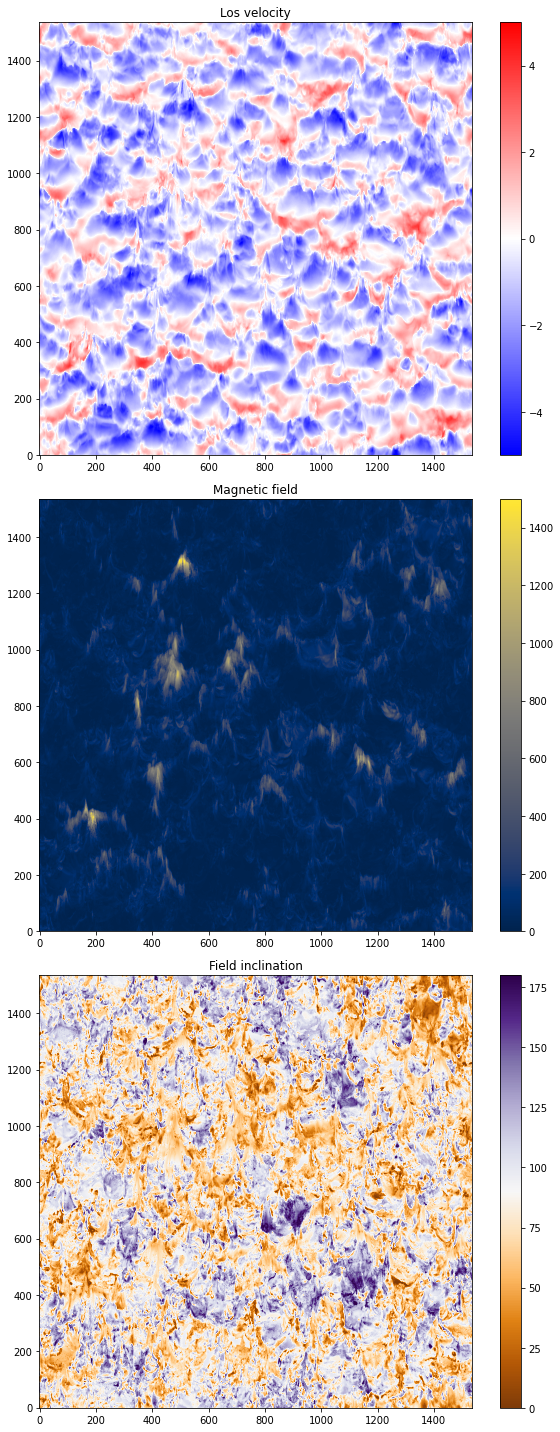

In [4]:
# The easiest sanity check for this is the velocity:
# Velocity is often normalized w.r.t the mean value 
plt.figure(figsize=[8,20])
plt.subplot(311)
plt.imshow(model_fit[:,:,3].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.title("Los velocity")
plt.colorbar()
plt.subplot(312)
plt.imshow(model_fit[:,:,0].T,cmap='cividis',origin='lower',vmin=0,vmax=1500)
plt.title("Magnetic field")
plt.colorbar()
plt.subplot(313)
plt.imshow(model_fit[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field inclination")
plt.colorbar()

plt.tight_layout()

# Let's look a little bit at the mean, mean de-projected B etc. 



In [5]:
B_los = model_fit[:,:,0] * np.cos(model_fit[:,:,1])
print (np.mean(B_los))

9.762142613362792


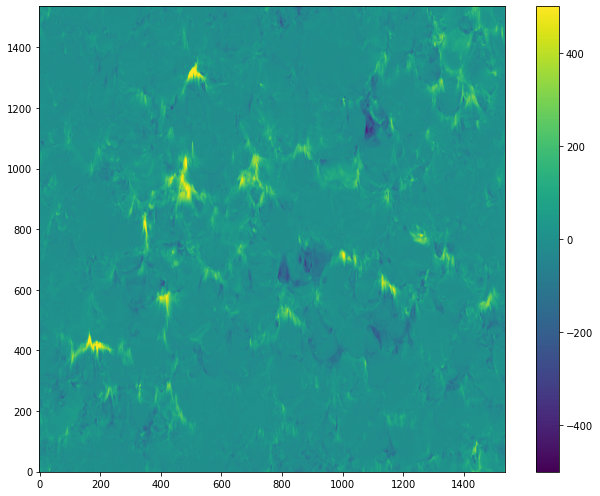

In [8]:
plt.figure(figsize=[9,7])
plt.imshow(B_los.T,vmin=-500,vmax=500,origin='lower')
plt.colorbar()
plt.tight_layout()

In [24]:
# Simply de-projecting the los magnetic field would yield 
mu = np.cos(np.radians(65))
print (mu)

0.42261826174069944


In [25]:
B_los_deprojected = B_los / mu
print (np.mean(B_los_deprojected))

23.099197306699498


In [29]:
myhdu = fits.PrimaryHDU(model_fit)
myhdu.writeto("inverted_original.fits",overwrite=True)

### Here we try some very simple disambiguation (hopefully less simple in the future)

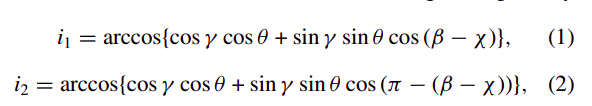

In [31]:
# Following Ito et al. (2009):
theta = np.radians(65)
beta = 0
i1 = np.arccos(np.cos(model_fit[:,:,1]) * np.cos(theta) + np.sin(model_fit[:,:,1]) \
               * np.sin(theta)* np.cos(beta - model_fit[:,:,2]))

i2 = np.arccos(np.cos(model_fit[:,:,1]) * np.cos(theta) + np.sin(model_fit[:,:,1]) \
               * np.sin(theta)* np.cos(np.pi - beta + model_fit[:,:,2]))

In [83]:
import numpy.ma as ma 
someB = ma.masked_where(model_fit[:,:,0]  > 200.0, model_fit[:,:,0])
someB.shape

(1536, 1536)

In [100]:
outward = np.zeros([1536,1536])
outward[:,:] = 90.0
i1 = np.degrees(i1)
i2 = np.degrees(i2)
for i in range(1536):
    for j in range(1536):
        if (i1[i,j] < 40.0 and i2[i,j] < 40.0):
            outward[i,j] = min(i1[i,j],i2[i,j])
        if (i1[i,j] > 140.0 and i2[i,j] > 140.0):
            outward[i,j] = max(i1[i,j],i2[i,j])
        #if (i1[i,j] > 40.0 and i1[i,j] < 110.0 and i1[i,j] > 40.0 and i1[i,j] < 110.0):
        #    outward
outward = np.radians(outward)

(array([      0.,       0.,       0.,       0.,       0., 2359296.,
              0.,       0.,       0.,       0.]),
 array([89.5, 89.6, 89.7, 89.8, 89.9, 90. , 90.1, 90.2, 90.3, 90.4, 90.5]),
 <BarContainer object of 10 artists>)

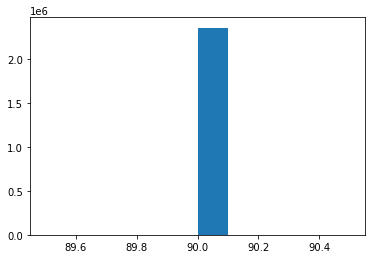

In [101]:
plt.hist(np.degrees(outward).flatten())

In [90]:
Bout = model_fit[:,:,0] * np.cos(outward)
print(np.mean(Bout))

40.76770128766673


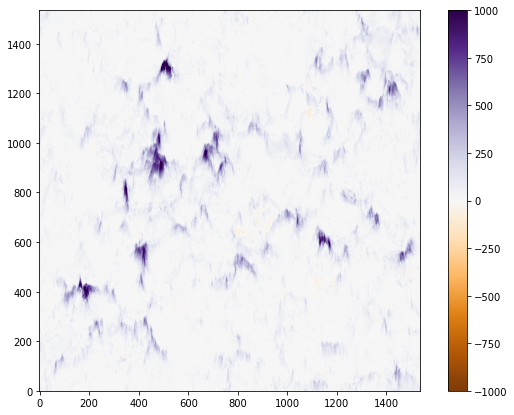

In [97]:
plt.figure(figsize=[10,7])
plt.imshow(Bout.T,vmin=-1000,vmax=1000,origin='lower',cmap='PuOr')
plt.colorbar()

### Try to see if the other line agrees. (Different heights)

In [ ]:
# Now we are going to try to invert that one spectra. 
# Inverting is fitting with M-E model.
# Let's try one line at the time. 

# What are the problems with inverting both lines simultaneously, can you discuss?
# We define wavelength regions. We will soon see what None refers to ;)

# We are inverting only the first one
ll_to_fit = ll[:100]
regions = [[ll_to_fit, None]]

# These are the lines
lines   = [6301]
# so now our code has wavelength grid and knows what to do

me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

In [ ]:
# We learned yesterday that we need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 10. #noise is typicaly larger for I, because of systematics - Discuss!

In [ ]:
%%time 
# This will tell us how much time we use

# Now we are going to select a region:
i = 0 # we start from here
j = 0 
nx = 768 # and take this big chunk
ny = 768

# The same as before
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
# Now we have 200 x 200 clones. In principle they don't have to be the same! 
models_guess  = me.repeat_model(model_guess, nx, ny)

# Select a Stokes subset to fit:
to_fit = stokes[i:i+nx,j:j+ny,:,:100].reshape(nx,ny,4,100)

# This is where the inversion happens, be mindful it will take some time
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 10, nIter=25, chi2_thres=1.0, verbose=False)

In [ ]:
# The easiest sanity check for this is the velocity:
# Velocity is often normalized w.r.t the mean value 
plt.figure(figsize=[7,20])
plt.subplot(311)
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.title("Los velocity")
plt.colorbar()
plt.subplot(312)
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower',vmin=0,vmax=2500)
plt.title("Magnetic field")
plt.colorbar()
plt.subplot(313)
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field inclination")
plt.colorbar()

plt.tight_layout()

In [ ]:
# Let's look a little bit at the mean, mean de-projected B etc. 

B_los = model_out[:,:,0] * np.cos(model_out[:,:,1])
print (np.mean(B_los))
# Simply de-projecting the los magnetic field would yield 
mu = np.cos(np.radians(65))
print (mu)
B_los_deprojected = B_los / mu
print (np.mean(B_los_deprojected))

## PSF + spatial binning

In [22]:
stokes_b1 = fits.open("degraded_1_3.fits")[0].data

In [23]:
stokes_b1.shape

(512, 219, 4, 302)

In [24]:
stokes_b1 = stokes_b1[:,:,:,101:]
ll = np.linspace(-500,1500,201)*1E-3 + 6301.49

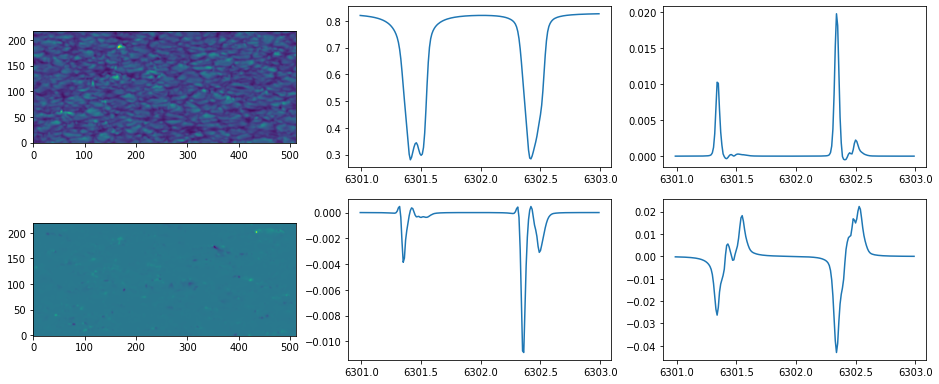

In [25]:
# Let's plot one example Stokes profile
i=360
j=170
plt.figure(figsize=[16,6.5])
plt.subplot(231)
plt.imshow(stokes_b1[:,:,0,0].T,origin='lower')
plt.subplot(234)
plt.imshow(stokes_b1[:,:,3,30].T,origin='lower')
plt.subplot(232)
plt.plot(ll,stokes_b1[i,j,0])
plt.subplot(233)
plt.plot(ll,stokes_b1[i,j,1])
plt.subplot(235)
plt.plot(ll,stokes_b1[i,j,2])
plt.subplot(236)
plt.plot(ll,stokes_b1[i,j,3])

In [26]:
# Now we are going to try to invert that one spectra. 
# Inverting is fitting with M-E model.
# Let's try one line at the time. 

# What are the problems with inverting both lines simultaneously, can you discuss?
# We define wavelength regions. We will soon see what None refers to ;)

# We are inverting only the first one
ll_to_fit = ll[100:]
regions = [[ll_to_fit, None]]

# These are the lines
lines   = [6302]
# so now our code has wavelength grid and knows what to do

me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


line::line: Initialized [6302.493100] ->   3 Zeeman components


In [27]:
# We learned yesterday that we need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 5. #noise is typicaly larger for I, because of systematics - Discuss!

In [28]:
%%time 
# This will tell us how much time we use

# Now we are going to select a region:
i = 0 # we start from here
j = 0 
nx = 512 # and take this big chunk
ny = 219

# The same as before
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
# Now we have 200 x 200 clones. In principle they don't have to be the same! 
models_guess  = me.repeat_model(model_guess, nx, ny)

# Select a Stokes subset to fit:
to_fit = stokes_b1[i:i+nx,j:j+ny,:,100:].reshape(nx,ny,4,101)

# This is where the inversion happens, be mindful it will take some time
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 10, nIter=25, chi2_thres=1.0, verbose=False)

CPU times: user 10min 25s, sys: 883 ms, total: 10min 26s
Wall time: 1min 34s


InvertMany: Processed -> 100%


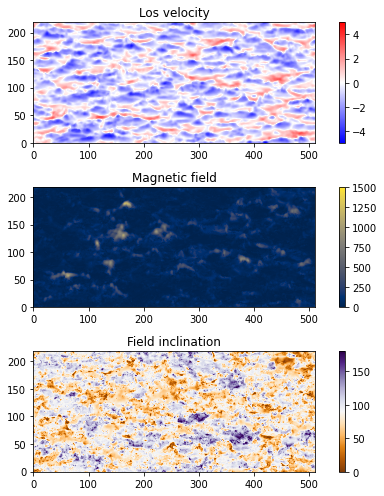

In [29]:
# The easiest sanity check for this is the velocity:
# Velocity is often normalized w.r.t the mean value 
plt.figure(figsize=[7,7])
plt.subplot(311)
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.title("Los velocity")
plt.colorbar()
plt.subplot(312)
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower',vmin=0,vmax=1500)
plt.title("Magnetic field")
plt.colorbar()
plt.subplot(313)
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field inclination")
plt.colorbar()

plt.tight_layout()

In [30]:
# Let's look a little bit at the mean, mean de-projected B etc. 

B_los = model_out[:,:,0] * np.cos(model_out[:,:,1])
print (np.mean(B_los))
# Simply de-projecting the los magnetic field would yield 
mu = np.cos(np.radians(65))
print (mu)
B_los_deprojected = B_los / mu
print (np.mean(B_los_deprojected))

9.432949
0.42261826174069944
22.32026
